In [1]:
# Calculation for the tracer age
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import gsw
import cmocean

In [2]:
datapath = '/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/'
def tracer_age_contour(s_dep, t):
    
    File01 = xr.open_dataset(datapath+'/state_'+str(format(s_dep,'03d'))+'.nc')
    File1 = File01.isel(T=~File01.get_index("T").duplicated())
    File02 = xr.open_dataset(datapath+'/ptracers_'+str(format(s_dep,'03d'))+'.nc')
    File2 = File02.isel(T=~File02.get_index("T").duplicated())
    File3 = xr.open_dataset(datapath+'/grid_'+str(format(s_dep,'03d'))+'.nc')

    state = File1.isel(X=range(1,260), Y=range(35,45), Yp1=range(35,45))
    ptracer = File2.isel(X=range(1,260), Y=range(35,45))
    grid = File3.isel(X=range(1,260),Y=range(35,45), Yp1=range(35,45))


    x_dist = state.X.data / 1000
    depth = state.Z.data
    time = state.T.data / 86400
    
    s = state.S.data[t,:,:,:].mean(1)
    pt = state.Temp.data[t,:,:,:].mean(1) # Potential temperature
    pres = gsw.p_from_z(depth, 55)
    p = np.tile(pres,[len(x_dist),1]).T
    rho = gsw.rho(s, pt, p) # Density
        
    alpha = ptracer.tr1_rlx.data[t,:,:,:].mean(1) # Age concentration (linearly increasing tracer concentration)
    C = ptracer.tr1_age.data[t,:,:,:].mean(1) # Total concentration (Constant tracer concentration)

    age = alpha * 1000 / C * time[t]
    age[age>time[t]] = time[t]
    
    s_ini = state.S.data[0,:,:,:].mean(1)
    mask = (s_ini == 0) # Exclude data covered by the sill
    rho[mask] = np.nan
    C[mask] = np.nan
    alpha[mask] = np.nan
    age[mask] = np.nan
    
    return rho, alpha, C, age

In [3]:
def State_t(case_id, t):

    file0 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')

    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45))
    
    X = state.X.data 
    x_dist = X / 1000
    depth = state.Z.data
    
    # Along-fjord velocity
    uzx = (state.U.data[:, :, :, 1:].mean(2) + state.U.data[:, :, :, :-1].mean(2)) / 2
    u = uzx[t,:,:]
    
    # Vetical velocity
    W0 = state.W.data
    bt = np.zeros((W0.shape[0],1,W0.shape[2],W0.shape[3])) # Add vertical velocity (0 m/s) at the bottom
    W = np.concatenate((W0, bt), axis=1)
    wzx = (W[:,1:,:,:].mean(2) + W[:,:-1,:,:].mean(2)) / 2
    w = wzx[t,:,:]
    
    pt0 = file.Temp.data.mean(2)[1,:,:260]
    mask = (pt0 == 0)
    u[mask] = np.nan
    w[mask] = np.nan   
        
    return (x_dist[1:], depth, u[:,1:], w[:,1:])

In [4]:
# state_ini = xr.open_dataset(datapath+'state_001.nc')
# state = state_ini.isel(X=range(1,260), Y=range(35,45), Yp1=range(35,45))

# x_dist = state.X.data / 1000
# depth = state.Z.data


CaseNum = np.array([1, 2, 3, 4, 5, 6])
hsr = np.array([1, 0.12, 0.04])
t = -1


x1, z1, u1, w1 = State_t(CaseNum[-1], t) # No sill case
x2, z2, u2, w2 = State_t(CaseNum[-2], t) # hs/h=0.12
x3, z3, u3, w3 = State_t(CaseNum[0], t) # hs/h=0.04


Rho1, A1, C1, Age1 = tracer_age_contour(CaseNum[-1], t)
Rho2, A2, C2, Age2 = tracer_age_contour(CaseNum[-2], t)
Rho3, A3, C3, Age3 = tracer_age_contour(CaseNum[0], t)

/home/1959/local/bin/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
def interp_vel (x, z, data, x_interp, z_interp):
    
    from scipy import interpolate
    z_r = -z
    data[np.isnan(data)] = 0
    sp_x = interpolate.RectBivariateSpline(z_r, x, data)
    n_data = sp_x(z_interp, x_interp)
    
    return n_data

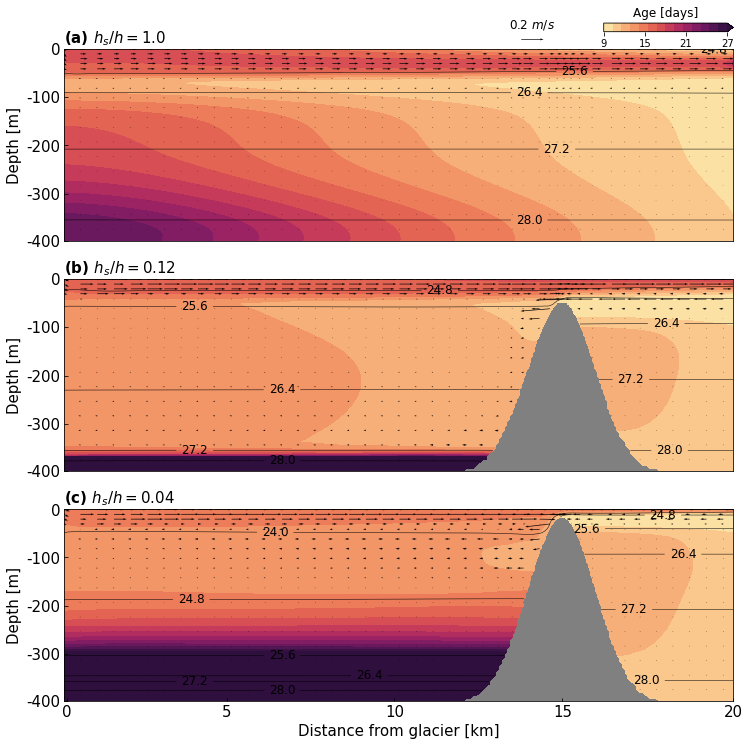

In [5]:
# Make plot for three different sill depths (New Runs)
fig1, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12))

cm = np.linspace(9,27,15) # Contour range
cmap = cmocean.cm.matter
#cmap = 'plasma_r'

x_dist = x1
depth = z1
im1 = ax1.contourf(x_dist, depth, Age1, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=15)


cbaxes = fig1.add_axes([0.75, 0.9, 0.15, 0.01])
cbar = fig1.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([9, 15, 21, 27])
cbar.ax.set_title(r'Age [days]', size=12)

# cbar1 = fig5.colorbar(im1, ax=ax1)
# cbar1.ax.set_title(r'Age [d]', size=12)
# cs1 = np.linspace(1015,1025,10)
# cs2 = np.linspace(1026,1030,10)

# CS1 = ax1.contour(x_dist, depth[:20], Rho1[:20,:], cs1, colors='b', linewidths=.5)
# plt.clabel(CS1, cs1[1::2], fmt='%1.1f', fontsize=12, inline=True)

# CS2 = ax1.contour(x_dist, depth[20:], Rho1[20:,:], cs2, colors='b', linewidths=.5)
# plt.clabel(CS2, cs2[:], fmt='%1.1f', fontsize=12, inline=True)
crho = np.linspace(1020,1028,11) - 1000 # Contour range for density
CS1 = ax1.contour(x_dist,depth,Rho1-1000,crho, colors='k', linewidths=.5)
plt.clabel(CS1, fmt='%1.1f', fontsize=12, inline=1)
ax1.xaxis.set_visible(False)
ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a) $h_s/h=1.0$', loc='left', size=15, weight='bold')


im2 = ax2.contourf(x_dist, depth, Age2, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=15)

# cbar2 = fig5.colorbar(im2, ax=ax2)
# cbar2.ax.set_title(r'Age [d]', size=12)

# cs3 = np.linspace(1015,1025,10)
# cs4 = np.linspace(1025,1030,10)
# CS3 = ax2.contour(x_dist, depth[:20], Rho2[:20,:], cs3, colors='b', linewidths=.5)
# plt.clabel(CS3, cs3[1::2], fmt='%1.1f', fontsize=12, inline=True)

# CS4 = ax2.contour(x_dist, depth[20:], Rho2[20:,:], cs4, colors='b', linewidths=.5)
# plt.clabel(CS4, cs4[:], fmt='%1.1f', fontsize=12, inline=True)
CS2 = ax2.contour(x_dist,depth,Rho2-1000,crho, colors='k', linewidths=.5)
plt.clabel(CS2, fmt='%1.1f', fontsize=12, inline=1)
ax2.xaxis.set_visible(False)
ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=15)
ax2.set_title(r'(b) $h_s/h=0.12$', loc='left', size=15, weight='bold')




im3 = ax3.contourf(x_dist, depth, Age3, cm, cmap=cmap, extend='max') # Z = 32~38 for -40~-60m
#ax1.axvline(x=x_dist[120], color='g',lw=2)
ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=15)

# cbar3 = fig5.colorbar(im3, ax=ax3)
# cbar3.ax.set_title(r'Age [d]', size=12)
# cs5 = np.linspace(1014,1025,10)
# cs6 = np.linspace(1024,1030,10)
# CS5 = ax3.contour(x_dist, depth[:20], Rho3[:20,:], cs5, colors='b', linewidths=.5)
# plt.clabel(CS5, cs5[1::2], fmt='%1.1f', fontsize=12, inline=True)

# CS6 = ax3.contour(x_dist, depth[20:], Rho3[20:,:], cs6, colors='b', linewidths=.5)
# plt.clabel(CS6, cs6[1::2], fmt='%1.1f', fontsize=12, inline=True)
CS3 = ax3.contour(x_dist,depth,Rho3-1000,crho, colors='k', linewidths=.5)
plt.clabel(CS3, fmt='%1.1f', fontsize=12, inline=1)
ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c) $h_s/h=0.04$', loc='left', size=15, weight='bold')
ax3.set_xticks([x_dist[1], 5, 10, 15, x_dist[-1]])
ax3.set_xticklabels(["0","5","10","15","20"])
ax3.set_xlabel('Distance from glacier [$km$]', size=15)



# x1n = np.linspace(x1.min(),x1.max(),50)
# z1n = np.linspace((-z1).min(),(-z1).max(),25)
# u1n = interp_vel(x1,z1,u1,x1n,z1n)
# w1n = interp_vel(x1,z1,w1,x1n,z1n)
# speed1 = np.sqrt(u1n**2 + w1n**2)
# lw1 = 5* speed1 / speed1.max()
# #ax1.hold(True)
# ax1.streamplot(x1n, -np.flip(z1n), np.flipud(u1n), np.flipud(w1n), 
#                density =[0.8, 0.4], color='k', linewidth=lw1)


# x2n = np.linspace(x2.min(),x2.max(),50)
# z2n = np.linspace((-z2).min(),(-z2).max(),25)
# u2n = interp_vel(x2,z2,u2,x2n,z2n)
# w2n = interp_vel(x2,z2,w2,x2n,z2n)
# speed2 = np.sqrt(u2n**2 + w2n**2)
# lw2 = 5* speed2 / speed2.max()
# #ax1.hold(True)
# ax2.streamplot(x2n, -np.flip(z2n), np.flipud(u2n), np.flipud(w2n), 
#                density =[0.8, 0.4], color='k', linewidth=lw2)

sl, sr = 140, 220 # quiver over sill range

u1_sill = u1[:,sl:sr]
w1_sill = w1[:,sl:sr]
x1_sill = x1[sl:sr]

n = 5
Q_1s = ax1.quiver(x1_sill[::10],z1[::n],u1_sill[::n,::10], w1_sill[::n,::10],scale=6, width=0.001, color='k')
u1[:,sl:sr] = 'nan'
w1[:,sl:sr] = 'nan'
Q_1 = ax1.quiver(x1[::n],z1[::n],u1[::n,::n], w1[::n,::n],scale=6, width=0.001, color='k')
ax1.quiverkey(Q_1, 0.7, 1.05, 0.2, r'0.2 $m\,s^{-1}$', fontproperties={'size':12}, coordinates='axes')


u2_sill = u2[:,sl:sr]
w2_sill = w2[:,sl:sr]
x2_sill = x2[sl:sr]
Q_2s = ax2.quiver(x2_sill[::10],z2[::n],u2_sill[::n,::10], w2_sill[::n,::10],scale=6, width=0.001, color='k')
u2[:,sl:sr] = 'nan'
w2[:,sl:sr] = 'nan'
Q_2 = ax2.quiver(x2[::n],z2[::n],u2[::n,::n], w2[::n,::n],scale=6, width=0.001, color='k')


u3_sill = u3[:,sl:sr]
w3_sill = w3[:,sl:sr]
x3_sill = x3[sl:sr]
Q_3s = ax3.quiver(x3_sill[::10],z3[::n],u3_sill[::n,::10], w3_sill[::n,::10],scale=6, width=0.001, color='k')

u3[:,sl:sr] = 'nan'
w3[:,sl:sr] = 'nan'
Q_3 = ax3.quiver(x3[::n],z3[::n],u3[::n,::n], w3[::n,::n],scale=6, width=0.001, color='k')


plt.show()

In [ ]:
x1

In [ ]:

plt.show()

In [6]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig1.savefig(fig_path + '/5-ptracer.png', dpi=300, bbox_inches='tight') 